In [1]:
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(harmony))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(harmony))
suppressMessages(library(Nebulosa))
suppressMessages(library(ggpubr))
suppressMessages(library(Ipaper))
suppressMessages(library(phateR))
suppressMessages(library(ComplexHeatmap))

In [2]:
## load TF activity
df_tf <- read.csv("../../../snATAC/HINT_Endothelial_V2/DiffFootprints/Heatmap/tf_activity.csv",
                 row.names = 1)
rownames(df_tf) <- stringr::str_split_fixed(rownames(df_tf), "\\.", 3)[, 3]

head(df_tf)

,Arterial_Endo,Capillary_Endo,Endocardial_Endo,Venous_Endo
,<dbl>,<dbl>,<dbl>,<dbl>
XBP1,1.3748360,0.09597042,-0.637986470,-0.8328199
STAT1,-1.2194869,-0.02627823,0.016171888,1.2295933
DUX4,0.4770181,0.06265044,-1.415021506,0.8753529
NFYA,1.2316269,0.17645631,-1.183942224,-0.2241410
EGR1,1.3350022,0.11876665,-0.455829271,-0.9979396
ESRRB,-1.2812785,0.12376559,-0.001368293,1.1588812


In [3]:
coembed <- readRDS("../data/coembed/coembed.annotation.Rds")

In [4]:
avg_exp <- AverageExpression(coembed, assays = "RNA", group.by = "annotation")$RNA
avg_exp <- avg_exp[, colnames(df_tf)]

avg_exp_scale <- as.data.frame(t(scale(t(avg_exp))))
avg_exp_scale <- tidyr::drop_na(avg_exp_scale)
write.csv(avg_exp, "../data/coembed/avg_exp.csv")

In [5]:
head(avg_exp_scale)

,Arterial_Endo,Capillary_Endo,Endocardial_Endo,Venous_Endo
,<dbl>,<dbl>,<dbl>,<dbl>
FAM87B,0.9436604,-0.6741272,0.7648815,-1.0344147
LINC01128,-0.2480912,0.5311774,1.0021860,-1.2852721
LINC00115,-1.0173823,0.2443130,-0.5096869,1.2827563
FAM41C,-0.1575176,-0.5687923,1.4558353,-0.7295253
LINC02593,-0.1351676,-0.2519718,-0.9987603,1.3858997
SAMD11,-0.7410545,-0.9123904,0.4721510,1.1812940


In [6]:
sel_tf <- intersect(rownames(avg_exp_scale), rownames(df_tf))

df_tf <- df_tf[sel_tf, ]
avg_exp_scale <- avg_exp_scale[sel_tf, colnames(df_tf)]

In [7]:
## compute correlation
df_cor <- cor(t(avg_exp_scale), t(df_tf), method = "pearson") %>%
    diag() %>%
    as.data.frame()

colnames(df_cor) <- "correlation"
df_cor$tf <- rownames(df_cor)

df_cor <- subset(df_cor, correlation > 0.5)

df_tf <- df_tf[df_cor$tf, ]
avg_exp_scale <- avg_exp_scale[df_cor$tf, ]

In [8]:
ht1 <- Heatmap(as.matrix(df_tf),
               name = "TF activity",
                             rect_gp = gpar(col = "black", lwd = 0.5),
             col = ArchR::paletteContinuous("blueYellow", n = 100),
            #row_order = row_order(ht),
             # column_order = column_order(ht),
             clustering_method_rows = "ward.D2",
              clustering_method_columns = "ward.D2"
              )

ht2 <- Heatmap(as.matrix(avg_exp_scale),
               name = "TF expression",
              row_order = row_order(ht1),
              column_order = column_order(ht1),
            rect_gp = gpar(col = "black", lwd = 0.5),
             col = ArchR::paletteContinuous("solarExtra", n = 100))

Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); column_order(ht)`.”


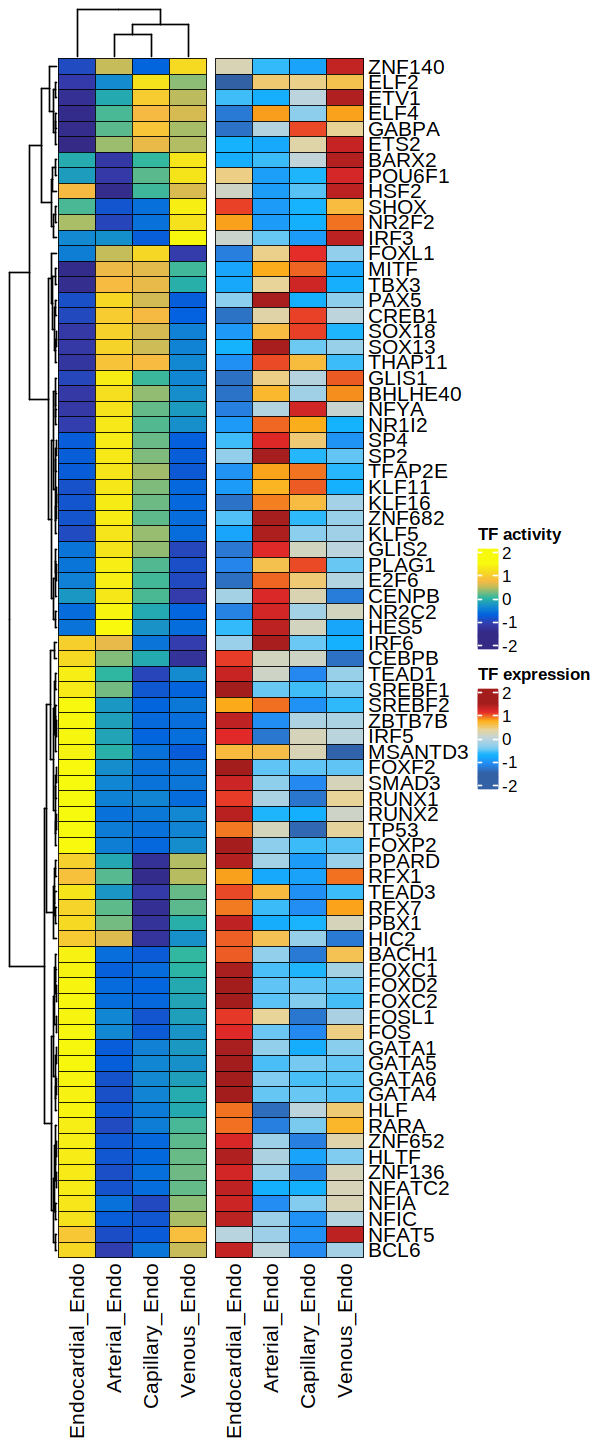

In [9]:
options(repr.plot.height = 12, repr.plot.width = 5)

ht1 + ht2